## script and function description
* script 01:use mne to read data(change corresponding filepath including eeglab data and montage data), and add 2 second segment events
    1. 50Hz and 1-100Hz filter =====> save epoch file
    2. do epochs =====> save epoch file
    3. local autorejection
* function 02: from Autoreject_report_plot this function is turned into py file, can simply use it by typing from from Autoreject_report_plot import from Autoreject_report_plot,  arguments' explanation 
    1. ar: autoreject object
    2. epochs: epochs that we fit ar object
    3.  epochs_preclean: epochs after autoreject transform
    4. reject_log : ar's log when transforming epochs
    5.  others are plot options


## _*script 01*_: filter->local autoreject-> ICA, an ICA file and cleaned epochs (optional) are saved at the end and some visualization plots can be selected to check rejecting rate
* ICA file: to select the components



In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
ICA fitting on Enrico data using MNE
===============================================
We firstly define subject dictionary as well as state list, reject dict, then we import eeglab format 
Raw data with MNE package.  
1) a notch filter to remove powerline artifact (50 Hz)
2) a 1Hz-100Hz band-pass filter
====> output = subj0*number*_*state*_filt_raw.fif  
3) Autorejection and ICA fitting: This is a parallel process of preprocessing, 
    the goal is to store two sets of ica component images and generate an exclude dict from that: 
        3)do epochs in order to autoreject bad epochs and observe rejection report ===> output: cleaned epochs
        3)ICA fit and save the ICA components to reject - this is done by using function ica_component_selection()
        ====> output = fif file that save ica object and a rejecting component dict



Note: exploration version

Suggestions:
1) try to decide decim variable to gain precision as well as time
2) 

Updated on June 2019

@author: Gansheng TAN aegean0045@outlook.com, Françoise Lecaignard, francoise.lecaignard@inserm.fr
"""
##############################################################  Set-up ################################################
import mne
import importlib
import numpy as np
import os
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from Autoreject_report_plot import Autoreject_report_plot #Gansheng
%matplotlib qt
mne.set_log_level('WARNING')
############## segment event creating #########################
events_998=np.array([512, 0, 998])
for i in np.arange(512*2,574*512,512*2):
    events_998=np.vstack((events_998,np.array([i, 0, 998])))

########################### 
# Variable definition
############################

################ inserm computer #####################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
epochs_raw_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_epochs_data/'
first_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/first_ar_file/'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
##################################################################################################

########### local laptop###################################################
# raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
# filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
# ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
# montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
############################################################################

subj_list = ['94']
state_list=['FA1']
power_freq_array = [50]
reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2'],
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
#example: reject_raw_data={'94':['FA1']}
bad_channel={'94':{'FA1':['Pz']}}
# example: bad_channel = {'94':{'FA1':['FP1','FP2'],{'VD1':['Cz']}} excluded for ICA analysis

############################## Visualisation selection ##############
plot_err_matrix = False
plot_filted_psd = False
plot_epochs_rej_intpl = True
plot_epochs_rejed =False
plot_drop_rate = False
plot_epochs_bfaft_compare = False
plot_chan_hist_thresh = True

############################## epochs parameter ##############################
event_id = {'2sec segment': 998}

############################## autorej and ICA parameters #####################
n_interpolate=np.array([1,2,3,4,5,6,32])
pca_n_comp=0.99
random_state=11 # to reproduce the same result
decim=3
save_ica_file = False
save_rejed_epochs = False
save_filt = False
save_first_ar = False
save_raw_epochs = False

############################## Generate mne report #########################################################

 
###########################
# preprocess one by one
###########################

###################### import subjects' raw eeglab file ################################################################

for subj in subj_list:
    for state in state_list:
        if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
            continue
        else:
            raw_fname = raw_data_path + 'subj0'+str(subj)+'_'+state+'_mast.set'
            montage_biosemi=mne.channels.read_montage(montage_path)
            raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
            events = mne.events_from_annotations(raw)
            events=np.asarray(events[0])
            events = np.array(np.vstack((events_998,events)))
            events=events[events[:,0].argsort()]
#            rep = Report(image_format = 'png', subject = 'subj0'+subj, raw_psd = True)
            #unique,counts = np.unique(events[:,0],return_counts=True)
            #events_unique_check=dict(zip(unique,counts))
            
            ################ events check, it is ok that we have two diff events in the same sample
#             for sample_nb in events_unique_check.keys():
#                 if events_unique_check[sample_nb] !=1:
#                     print(sample_nb)
#                     print(events_unique_check[sample_nb])
#             print("events nb unique check is done")
       
            
            ############## note bad channels ########################################################################
            raw.info['bads']=bad_channel[subj][state]
            
            ############## filter 1-100Hz and notch 50 ##################################################################
            raw_filt = raw.copy()
            raw_filt.notch_filter(freqs=power_freq_array)
            raw_filt.filter(l_freq=1,h_freq=100)
            if plot_filted_psd == True:
                raw_filt.plot_psd()  #check filter
            if save_filt:
                f_raw_filt = filt_data_path+'subj0'+subj+'_'+state+'_filt_raw.fif'
                raw_filt.save(f_raw_filt,overwrite=True)
#             figs=list()
#             figs.append(raw.plot_psd())
#             figs.append(raw_filt.plot_psd())
#             captions=['psd of raw data', 'psd of raw data after filter']
#             rep.add_figs_to_section(figs=figs, captions=captions, section = 'spectral plot', image_format = 'svg')

            
            ############## do epochs ####################################################################################
            epochs=mne.Epochs(raw_filt,events=events, event_id = event_id, tmin=-1, tmax=1,preload=True)
            epochs.event_id
            if save_raw_epochs == True:
                f_raw_epochs_out= epochs_raw_path + 'subj0'+subj+'_'+state+'_raw_epo.fif'
                epochs.save(f_raw_epochs_out, overwrite=True)
                #### epochs is filtered
                
            
            ########################### event info manipulation #############
#             rej = epochs.drop_log

#             for i in range(len(rej)):
#                 if rej[i] == list():
#                     continue
#                 else:
#                     rej[i]=list()
            

            ############## Auto rejection - local threshold #############################################################
            picks = mne.pick_types(epochs.info, meg=False, eeg=True, stim=False,
                       eog=False)
            ar = AutoReject(picks=picks,n_interpolate=n_interpolate,random_state=random_state,verbose='tqdm')
            ar=ar.fit(epochs)
            epochs_preclean, reject_log = ar.transform(epochs, return_log=True)
            if save_first_ar ==True:
                f_first_ar_out = first_ar_file_path  + 'subj0'+subj+'_'+state+'_first_ar.fif'
                ar.save(f_first_ar_out,overwrite=True)
            
            if save_rejed_epochs ==True:
                f_rejed_epochs_out= epochs_autorejed_path + 'subj0'+subj+'_'+state+'_autorejed_epo.fif'
                epochs_preclean.save(f_rejed_epochs_out,overwrite=True)
            
            figs = Autoreject_report_plot(ar,epochs,epochs_preclean,reject_log,plot_err_matrix = plot_err_matrix,
                                   plot_epochs_rej_intpl = plot_epochs_rej_intpl,
                                   plot_epochs_rejed =plot_epochs_rejed,plot_drop_rate = plot_drop_rate,
                                   plot_epochs_bfaft_compare = plot_epochs_bfaft_compare,
                                   plot_chan_hist_thresh = plot_chan_hist_thresh)
            
            ############### ICA fit #####################################################################################
            ica = mne.preprocessing.ICA(n_components=pca_n_comp, method='fastica', random_state=11, max_iter=100)
            ica.fit(epochs[~reject_log.bad_epochs],decim=decim)

            #ica.plot_components(inst=epochs)

            
            ############## save ICA file and then read them in auto-process to reject ICA component ###################
            f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
            if save_ica_file == True:
                ica.save(f_ica)
                print("ICA file successfully saved")
            else:
                print("ICA file not saved")
            
            ############################## save report ###############################################################
#             f_report = report_path + 'subj0' + subj+ state+'.html'
#             rep.save(f_report, open_browser = False, overwrite = False)

            

/home/gansheng.tan/mne/local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_FA1_mast.fdt
Reading 0 ... 294399  =      0.000 ...   574.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

/home/gansheng.tan/mne/local/lib/python3.5/site-packages/autoreject/utils.py:75: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  'remove them from epochs.info["bads"].' % n_bads)


Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 63/63 [03:02<00:00,  2.71s/it]


Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   4%|▍         | 11/287 [00:00<00:02, 104.81it/s]

Repairing epochs:   9%|▊         | 25/287 [00:00<00:02, 112.23it/s]

Repairing epochs:  14%|█▎        | 39/287 [00:00<00:02, 117.19it/s]

Repairing epochs:  18%|█▊        | 53/287 [00:00<00:01, 121.74it/s]

Repairing epochs:  23%|██▎       | 67/287 [00:00<00:01, 124.91it/s]

Repairing epochs:  27%|██▋       | 78/287 [00:00<00:01, 116.10it/s]

Repairing epochs:  31%|███▏      | 90/287 [00:00<00:02, 96.28it/s] 

Repairing epochs:  36%|███▌      | 104/287 [00:00<00:01, 104.81it/s]

Repairing epochs:  41%|████      | 118/287 [00:01<00:01, 112.04it/s]

Repairing epochs:  46%|████▌     | 132/287 [00:01<00:01, 117.70it/s]

Repairing epochs:  51%|█████     | 146/287 [00:01<00:01, 121.99it/s]

Repairing epochs:  56%|█████▋    | 162/287 [00:01<00:00, 130.37it/s]

Repairing epochs:  63%|██████▎  

Repairing epochs:  69%|██████▉   | 198/287 [00:05<00:02, 39.87it/s]

Repairing epochs:  71%|███████   | 203/287 [00:05<00:02, 39.12it/s]

Repairing epochs:  72%|███████▏  | 207/287 [00:05<00:02, 38.12it/s]

Repairing epochs:  74%|███████▎  | 211/287 [00:05<00:02, 37.98it/s]

Repairing epochs:  75%|███████▍  | 215/287 [00:05<00:01, 37.63it/s]

Repairing epochs:  76%|███████▋  | 219/287 [00:05<00:01, 37.42it/s]

Repairing epochs:  78%|███████▊  | 223/287 [00:05<00:01, 37.54it/s]

Repairing epochs:  79%|███████▉  | 227/287 [00:06<00:01, 37.09it/s]

Repairing epochs:  80%|████████  | 231/287 [00:06<00:01, 37.16it/s]

Repairing epochs:  82%|████████▏ | 236/287 [00:06<00:01, 39.96it/s]

Repairing epochs:  84%|████████▍ | 242/287 [00:06<00:01, 43.02it/s]

Repairing epochs:  86%|████████▌ | 247/287 [00:06<00:00, 44.66it/s]

Repairing epochs:  88%|████████▊ | 252/287 [00:06<00:00, 41.74it/s]

Repairing epochs:  90%|████████▉ | 257/287 [00:06<00:00, 39.74it/s]

Repairing epochs:  91%|█████████▏|

Repairing epochs:  50%|████▉     | 143/287 [00:03<00:03, 38.53it/s]

Repairing epochs:  51%|█████     | 147/287 [00:04<00:03, 36.87it/s]

Repairing epochs:  53%|█████▎    | 152/287 [00:04<00:03, 39.22it/s]

Repairing epochs:  55%|█████▍    | 157/287 [00:04<00:03, 39.85it/s]

Repairing epochs:  56%|█████▋    | 162/287 [00:04<00:03, 38.67it/s]

Repairing epochs:  58%|█████▊    | 166/287 [00:04<00:03, 36.00it/s]

Repairing epochs:  59%|█████▉    | 170/287 [00:04<00:03, 35.77it/s]

Repairing epochs:  61%|██████    | 174/287 [00:04<00:03, 34.15it/s]

Repairing epochs:  62%|██████▏   | 178/287 [00:04<00:03, 33.72it/s]

Repairing epochs:  63%|██████▎   | 182/287 [00:05<00:03, 34.96it/s]

Repairing epochs:  65%|██████▍   | 186/287 [00:05<00:02, 35.70it/s]

Repairing epochs:  66%|██████▌   | 190/287 [00:05<00:02, 36.31it/s]

Repairing epochs:  68%|██████▊   | 194/287 [00:05<00:02, 35.23it/s]

Repairing epochs:  69%|██████▉   | 198/287 [00:05<00:02, 34.61it/s]

Repairing epochs:  70%|███████   |





Estimated consensus=1.00 and n_interpolate=32




Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 2/287 [00:00<00:19, 14.99it/s]

Repairing epochs:   2%|▏         | 5/287 [00:00<00:16, 17.44it/s]

Repairing epochs:   3%|▎         | 8/287 [00:00<00:14, 19.66it/s]

Repairing epochs:   4%|▍         | 12/287 [00:00<00:12, 22.30it/s]

Repairing epochs:   6%|▌         | 16/287 [00:00<00:10, 24.77it/s]

Repairing epochs:   7%|▋         | 20/287 [00:00<00:09, 26.95it/s]

Repairing epochs:   8%|▊         | 24/287 [00:00<00:08, 29.35it/s]

Repairing epochs:  10%|▉         | 28/287 [00:00<00:08, 31.01it/s]

Repairing epochs:  11%|█         | 32/287 [00:01<00:07, 32.75it/s]

Repairing epochs:  13%|█▎        | 36/287 [00:01<00:09, 27.45it/s]

Repairing epochs:  14%|█▍        | 41/287 [00:01<00:08, 30.66it/s]

Repairing epochs:  16%|█▌        | 45/287 [00:01<00:07, 32.27it/s]

Repairing epochs:  17%|█▋        | 49/287 [00:01<00:07, 33.58it/s]

Repairing epochs:  18%|█▊        | 53/287 [00:01<00:06, 34

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


ICA file not saved


In [19]:
epochs_icaexcluded_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/icaexcluded_epochs_data/'
epochs_second_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_autorejected_epochs_data/'
second_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_ar_file/'

from autoreject import read_auto_reject
f_epochs_final = epochs_second_autorejed_path + 'subj0'+str(subj)+'_'+state+'_second_autorejed_epo.fif'
epochs_final = mne.read_epochs(f_epochs_final)
f_second_autorej_ar = second_ar_file_path + 'subj0'+str(subj)+'_'+state+'_second_ar.fif'
ar_second= read_auto_reject(f_second_autorej_ar)

f_epochs_icaexcluded = epochs_icaexcluded_path + 'subj0'+str(subj)+'_'+state+'_icaexcluded_epo.fif'
epochs_icaexcluded=mne.read_epochs(f_epochs_icaexcluded)

reject_log=ar_second.get_reject_log(epochs_icaexcluded)

%matplotlib qt
Autoreject_report_plot(ar_second,epochs_icaexcluded,epochs_final,reject_log,plot_err_matrix = False,
                                   plot_epochs_rej_intpl = False,
                                   plot_epochs_rejed =False,plot_drop_rate = False,
                                   plot_epochs_bfaft_compare = False,
                                   plot_chan_hist_thresh = True)

/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


## Selection ICA components

In [13]:
from ica_component_selection import ica_component_selection
## fill this dict
ica_selection = { '94':[0,7,9,19]}
%matplotlib qt
## run this function to see the data
ica_component_selection('94','FA1',second_check=True)

no Veog component is found, data is cleaned from eog
select the removing components and fill the ica_selection dict


True

##  exclude ICA artifact components (and potentially second autoreject)
* apply ICA on raw epochs

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
ICA components selection on Enrico data using MNE
===============================================

We firstly load cleaned epochs and ICA file
1) exclude ICA components based on ica_selection dict
2) optional autoreject
====> output = icaed_rej2.fif



Note: In current stage, this script is developped and tested using one subject in local computer,in order to run it in cluster,
one need to change the raw_data path. Same for states.(we have FA1,FA2,VD1,VD2,OP1,OP2)

Suggestions:
1) use np.arange to generate subject list, do not forget to add 0 for subject number ranging from 1 to 9
2) generate a csv file(or print to console) to summarise how many raw data read and how many 
    raw data is rejected
Updated on June 2019

@author: Gansheng TAN aegean0045@outlook.com, Françoise Lecaignard, francoise.lecaignard@inserm.fr
"""
##############################################################  Set-up ######################################################################

import mne
import importlib
import numpy as np
import os
from autoreject import AutoReject
from Autoreject_report_plot import Autoreject_report_plot
mne.set_log_level('WARNING')

#################################### step00 import subjects' raw eeglab file ################################################################

########################### 
# Variable definition
############################
################ inserm computer #####################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
epochs_icaexcluded_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/icaexcluded_epochs_data/'
epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
epochs_second_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_autorejected_epochs_data/'
second_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_ar_file/'
epochs_raw_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_epochs_data/'
##################################################################################################

########### local laptop###################################################
# raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
# filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
# ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
# montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
############################################################################

subj_list = ['94']
state_list=['FA1']
save_filt = True
power_freq_array = [50]
reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2'],
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
#example: reject_raw_data={'94':['FA1']}
ica_selection = {'94':{'FA1':[0,7,9,19]}}
save_ica_excluded_file = True
save_ica_excluded_epochs = True
second_autorej = True
save_second_rejed_epochs = False
save_second_ar = True

############################## Visualisation selection ##############
plot_err_matrix = False
plot_filted_psd = False
plot_epochs_rej_intpl = True
plot_epochs_rejed =False
plot_drop_rate = False
plot_epochs_bfaft_compare = False
plot_chan_hist_thresh = True
# check autoreject_report_plot arfuments to visualize

################################# second autorejection parameters ############################
#n_interpolate = [1,4,8,32]
random_state = 11

###########################
# ICA components exclusion
###########################
for subj in subj_list:
    for state in state_list:
        if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
            print("the recording file is of low quality, so discarded")
            continue
        else:
            
            f_raw_epochs = epochs_raw_path + 'subj0'+subj+'_'+state+'_raw_epo.fif'
            epochs = mne.read_epochs(f_raw_epochs,preload=True)


            f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
            ica = mne.preprocessing.read_ica(f_ica)

            ica.exclude = ica_selection[subj][state]
            f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_excluded_ica.fif'
            if save_ica_excluded_file == True:
                ica.save(f_ica)
                print("exclued components done, updated ica file is saved")
                 
            epochs_ica_excluded = epochs.copy()
            ica.apply(epochs_ica_excluded)
            if save_ica_excluded_epochs == True:
                f_epochs_ica_excluded = epochs_icaexcluded_path + 'subj0'+subj+'_'+state+'_icaexcluded_epo.fif'
                epochs_ica_excluded.save(f_epochs_ica_excluded,overwrite=True)
                print("epochs after selecting ica component are saved")

        
##########################
# second autoreject
##########################
            ############## Second Auto rejection - local threshold #####################################################
            if second_autorej == True:
                epochs_second_autorejed=epochs_ica_excluded.copy()
                picks = mne.pick_types(epochs_second_autorejed.info, meg=False, eeg=True, stim=False,
                       eog=False)
                ar = AutoReject(picks=picks,random_state=random_state,verbose='tqdm')
                ar=ar.fit(epochs_second_autorejed)
                epochs_second_autorejed, reject_log = ar.transform(epochs_second_autorejed, return_log=True)
                if save_second_ar ==True:
                    f_second_ar_out = second_ar_file_path  + 'subj0'+subj+'_'+state+'_second_ar.fif'
                    ar.save(f_second_ar_out,overwrite=True)
            
                if save_second_rejed_epochs ==True:
                    f_rejed_epochs_out= epochs_second_autorejed_path + 'subj0'+subj+'_'+state+'_second_autorejed_epo.fif'
                    epochs_second_autorejed.save(f_rejed_epochs_out,overwriterite=True)

                Autoreject_report_plot(ar,epochs_ica_excluded,epochs_second_autorejed,reject_log,plot_err_matrix = plot_chan_hist_thresh,
                                       plot_epochs_rej_intpl = plot_epochs_rej_intpl,plot_epochs_rejed =plot_epochs_rejed,
                                       plot_drop_rate = plot_drop_rate,plot_epochs_bfaft_compare = plot_epochs_bfaft_compare,
                                       plot_chan_hist_thresh = plot_chan_hist_thresh)

exclued components done, updated ica file is saved
Overwriting existing file.
epochs after selecting ica component are saved
Running autoreject on ch_type=eeg


/home/gansheng.tan/mne/local/lib/python3.5/site-packages/autoreject/utils.py:75: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  'remove them from epochs.info["bads"].' % n_bads)
Computing thresholds ...: 100%|██████████| 63/63 [03:08<00:00,  2.99s/it]


Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 9/287 [00:00<00:03, 87.37it/s]

Repairing epochs:   7%|▋         | 21/287 [00:00<00:02, 94.99it/s]

Repairing epochs:  12%|█▏        | 34/287 [00:00<00:02, 102.18it/s]

Repairing epochs:  15%|█▌        | 44/287 [00:00<00:02, 99.96it/s] 

Repairing epochs:  20%|██        | 58/287 [00:00<00:02, 109.13it/s]

Repairing epochs:  26%|██▌       | 74/287 [00:00<00:01, 120.51it/s]

Repairing epochs:  30%|██▉       | 86/287 [00:00<00:01, 113.71it/s]

Repairing epochs:  34%|███▍      | 98/287 [00:00<00:01, 110.67it/s]

Repairing epochs:  40%|█

Repairing epochs:  61%|██████    | 174/287 [00:04<00:02, 40.84it/s]

Repairing epochs:  62%|██████▏   | 179/287 [00:04<00:02, 38.69it/s]

Repairing epochs:  64%|██████▍   | 184/287 [00:04<00:02, 40.10it/s]

Repairing epochs:  66%|██████▌   | 189/287 [00:04<00:02, 38.96it/s]

Repairing epochs:  67%|██████▋   | 193/287 [00:04<00:02, 38.52it/s]

Repairing epochs:  69%|██████▊   | 197/287 [00:05<00:02, 37.59it/s]

Repairing epochs:  70%|███████   | 201/287 [00:05<00:02, 37.16it/s]

Repairing epochs:  71%|███████▏  | 205/287 [00:05<00:02, 37.27it/s]

Repairing epochs:  73%|███████▎  | 209/287 [00:05<00:02, 35.27it/s]

Repairing epochs:  74%|███████▍  | 213/287 [00:05<00:02, 34.52it/s]

Repairing epochs:  76%|███████▌  | 217/287 [00:05<00:01, 35.22it/s]

Repairing epochs:  77%|███████▋  | 221/287 [00:05<00:01, 35.50it/s]

Repairing epochs:  78%|███████▊  | 225/287 [00:05<00:01, 36.62it/s]

Repairing epochs:  80%|███████▉  | 229/287 [00:05<00:01, 35.79it/s]

Repairing epochs:  82%|████████▏ |





Estimated consensus=0.30 and n_interpolate=4




Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 2/287 [00:00<00:14, 19.35it/s]

Repairing epochs:   2%|▏         | 6/287 [00:00<00:12, 22.47it/s]

Repairing epochs:   3%|▎         | 10/287 [00:00<00:11, 23.94it/s]

Repairing epochs:   5%|▍         | 13/287 [00:00<00:11, 24.85it/s]

Repairing epochs:   6%|▌         | 17/287 [00:00<00:10, 26.55it/s]

Repairing epochs:   7%|▋         | 21/287 [00:00<00:09, 28.78it/s]

Repairing epochs:   8%|▊         | 24/287 [00:00<00:09, 29.14it/s]

Repairing epochs:  10%|▉         | 28/287 [00:00<00:08, 31.30it/s]

Repairing epochs:  11%|█         | 32/287 [00:01<00:07, 32.86it/s]

Repairing epochs:  13%|█▎        | 37/287 [00:01<00:06, 35.74it/s]

Repairing epochs:  15%|█▍        | 42/287 [00:01<00:06, 38.73it/s]

Repairing epochs:  16%|█▋        | 47/287 [00:01<00:06, 37.68it/s]

Repairing epochs:  18%|█▊        | 51/287 [00:01<00:06, 38.13it/s]

Repairing epochs:  19%|█▉        | 55/287 [00:01<00:06, 3

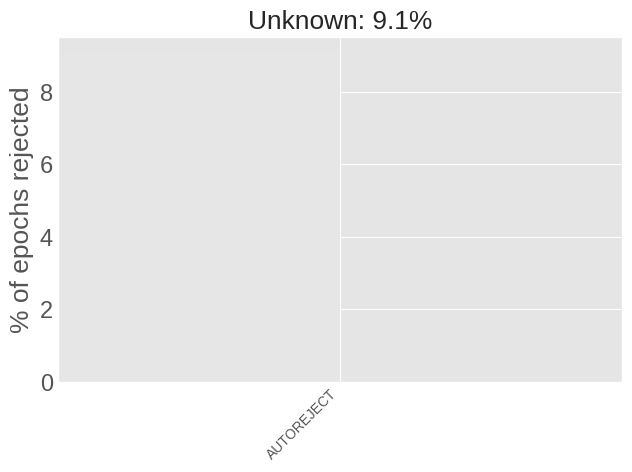

In [14]:
epochs_second_autorejed.plot_drop_log()

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_FA1_mast.fdt
Reading 0 ... 294399  =      0.000 ...   574.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

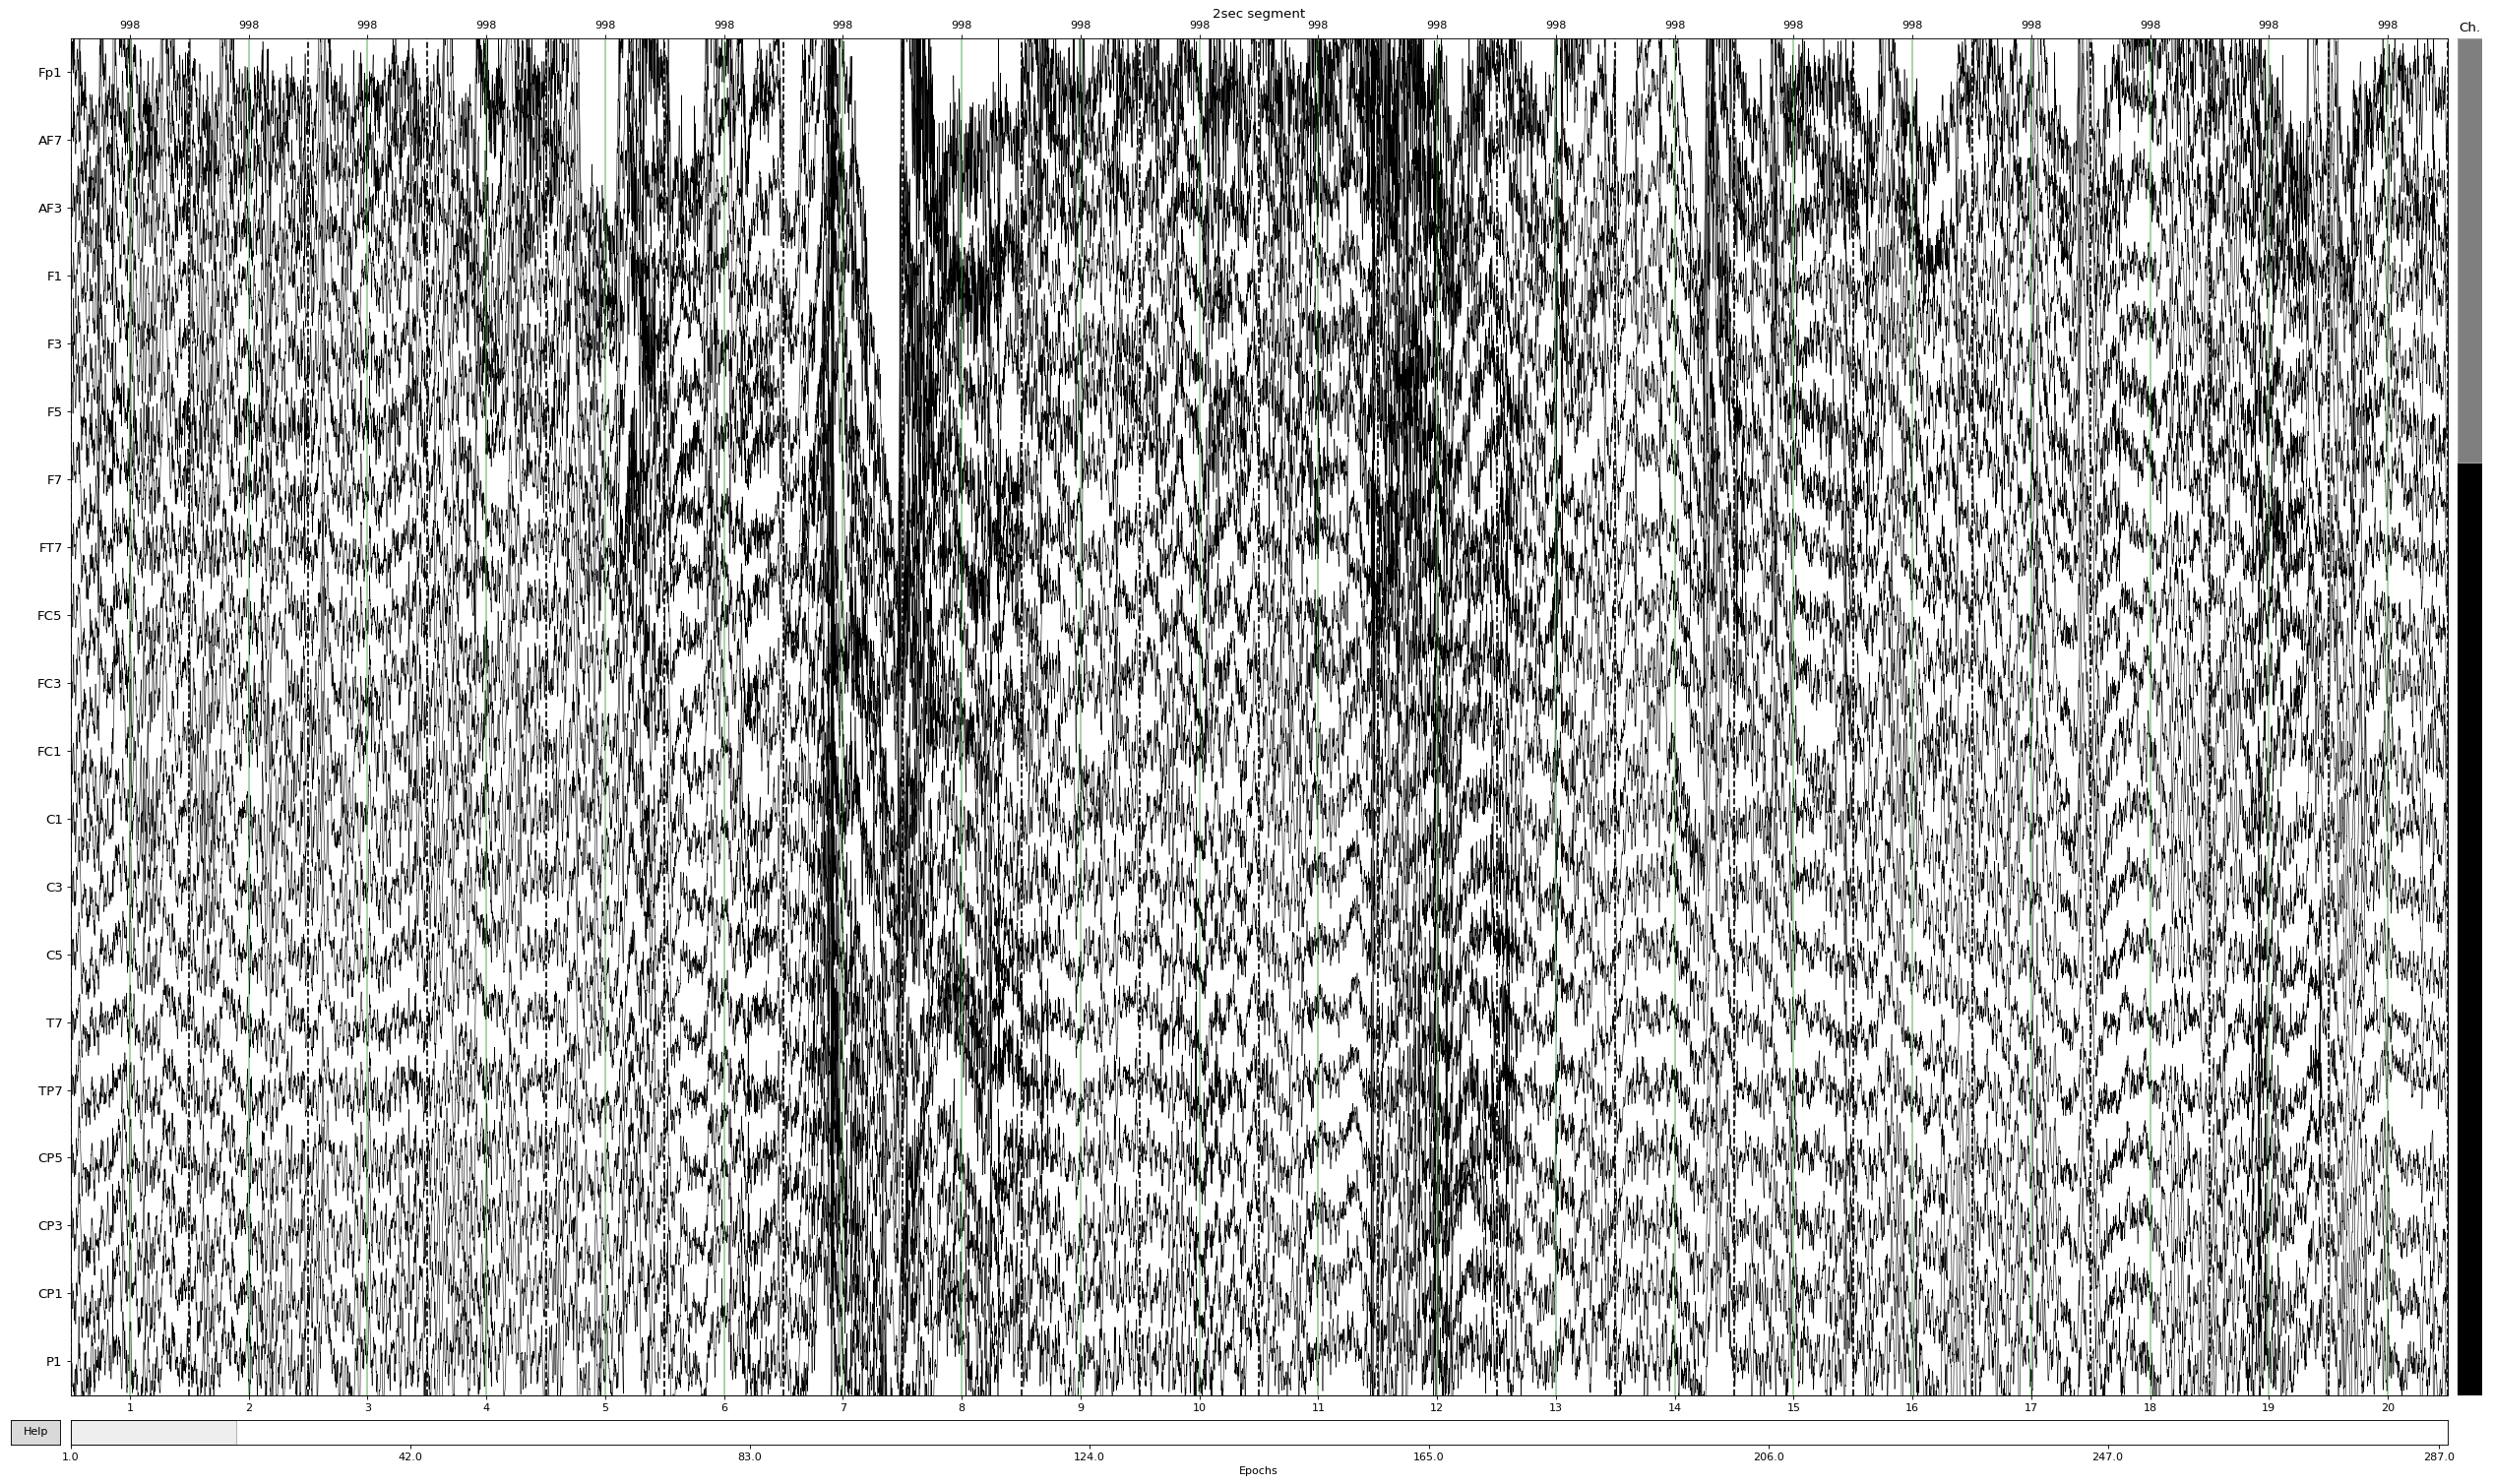

In [14]:
epochs_second_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_autorejected_epochs_data/'
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
power_freq_array = [50]
subj='94'
state='FA1'
filename_epochs = epochs_second_autorejed_path+ 'subj0'+subj+'_'+state+'_second_autorejed_epo.fif'
final_epochs = mne.read_epochs(filename_epochs,preload=True)
filename_epochs = epochs_second_autorejed_path+ 'subj0'+subj+'_'+state+'_second_autorejed_epo.fif'

raw_fname = raw_data_path + 'subj0'+str(subj)+'_'+state+'_mast.set'
montage_biosemi=mne.channels.read_montage(montage_path)
raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
raw_filt = raw.copy()
raw_filt.notch_filter(freqs=power_freq_array)
raw_filt.filter(l_freq=1,h_freq=100)
event_id = {'2sec segment': 998}
events_998=np.array([512, 0, 998])
for i in np.arange(512*2,574*512,512*2):
    events_998=np.vstack((events_998,np.array([i, 0, 998])))
events = mne.events_from_annotations(raw)
events=np.asarray(events[0])
events = np.array(np.vstack((events_998,events)))
events=events[events[:,0].argsort()]
epochs=mne.Epochs(raw_filt,events=events, event_id = event_id, tmin=-1, tmax=1,preload=True)

epochs.plot()

In [157]:
# fast plot without fitting

from ica_component_selection import ica_component_selection
import mne

################ inserm computer #####################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
epochs_icaexcluded_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/icaexcluded_epochs_data/'
epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
epochs_second_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_autorejected_epochs_data/'
second_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_ar_file/'
##################################################################################################

########### local laptop###################################################
# raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
# filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
# ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
# montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
############################################################################

# check before ica and after ica - change second_check to True
ica_component_selection('94','FA1',HEOG_corr=False, VEOG_corr=True,second_check=False)

# check epoch before and after autorej
epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
%matplotlib qt
epochs_autorejed=mne.read_epochs(epochs_autorejed_path+'subj094_FA1_autorejed_epo.fif')
#epochs_ica_excluded.plot()
epochs_icaexcluded_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/icaexcluded_epochs_data/'
epochs_icaexcluded=mne.read_epochs(epochs_icaexcluded_path+'subj094_FA1_icaexcluded_epo.fif')
epochs_icaexcluded.plot(n_channels=64,n_epochs=5,scalings=dict(eeg=100e-6),title="epochs plot after ica rejection")
# subj='94'
# state='FA1'
second_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_ar_file/'
epochs_second_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_autorejected_epochs_data/'

# epochs_autorejed.plot(n_channels=64,n_epochs=5,scalings=dict(eeg=100e-6),title="epochs plot after first autorejection")
Autoreject_report_plot(ar,epochs_ica_excluded,epochs_second_autorejed,reject_log,plot_err_matrix = plot_chan_hist_thresh,
                                       plot_epochs_rej_intpl = plot_epochs_rej_intpl,plot_epochs_rejed =plot_epochs_rejed,
                                       plot_drop_rate = plot_drop_rate,plot_epochs_bfaft_compare = plot_epochs_bfaft_compare,
                                       plot_chan_hist_thresh = plot_chan_hist_thresh)


select the removing components and fill the ica_selection dict


True

In [7]:
from ica_component_selection import ica_component_selection
%matplotlib qt
ica_component_selection('94','FA1',HEOG_corr=True, VEOG_corr=True,second_check=False)

select the removing components and fill the ica_selection dict


True

In [160]:
from autoreject import AutoReject
import autoreject
second_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_ar_file/'
ar = AutoReject(second_ar_file_path+ 'subj0'+subj+'_'+state+'_second_autorejed_epo.fif')
ar.consensus

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## To check whether autorej can detect the bad channel that we marked
do not save ar object, this will sabotage the naming method
take 6mins to run
according to ar, Pz is a good channel

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
ICA fitting on Enrico data using MNE
===============================================
We firstly define subject dictionary as well as state list, reject dict, then we import eeglab format Raw data with MNE package.  
1) a notch filter to remove powerline artifact (50 Hz)
2) a 0.1Hz high-pass filter
====> output = subj0*number*_*state*_filt_raw.fif  
3) Autorejection and ICA fitting: This is a parallel process of preprocessing, 
    the goal is to store two sets of ica component images and generate an exclude dict from that: 
        3)do epochs in order to autoreject bad epochs and observe rejection report ===> output: cleaned epochs
        3)ICA fit and save the ICA components to reject - this is done by using function ica_component_selection()
        ====> output = fif file that save ica object and a rejecting component dict



Note: exploration version

Suggestions:
1) try to decide decim variable to gain precision as well as time
2) 

Updated on June 2019

@author: Gansheng TAN aegean0045@outlook.com, Françoise Lecaignard, francoise.lecaignard@inserm.fr
"""
##############################################################  Set-up ######################################################################

import mne
import importlib
import numpy as np
import os
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from Autoreject_report_plot import Autoreject_report_plot #Gansheng
%matplotlib qt
mne.set_log_level('WARNING')
############## segment event creating #########################
events_998=np.array([512, 0, 998])
for i in np.arange(512*2,574*512,512*2):
    events_998=np.vstack((events_998,np.array([i, 0, 998])))

########################### 
# Variable definition
############################

################ inserm computer #####################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
first_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/first_ar_file/'
##################################################################################################

########### local laptop###################################################
# raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
# filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
# ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
# montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
############################################################################

subj_list = ['94']
state_list=['FA1']
power_freq_array = [50]
reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2'],
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
#example: reject_raw_data={'94':['FA1']}
bad_channel={'94':{'FA1':[]}}
# example: bad_channel = {'94':{'FA1':['FP1','FP2'],{'VD1':['Cz']}} excluded for ICA analysis

############################## Visualisation selection ##############
plot_err_matrix = False
plot_filted_psd = False
plot_epochs_rej_intpl = True
plot_epochs_rejed =False
plot_drop_rate = False
plot_epochs_bfaft_compare = False
plot_chan_hist_thresh = True

############################## epochs parameter ##############################
event_id = {'2sec segment': 998}

############################## autorej and ICA parameters #####################
n_interpolate=np.array([1,2,3,4,5,6,32])
pca_n_comp=0.99
random_state=11 # to reproduce the same result
decim=3
save_ica_file = False
save_rejed_epochs = False
save_filt = False
save_first_ar = False
###########################
# preprocess one by one
###########################

###################### import subjects' raw eeglab file ################################################################

for subj in subj_list:
    for state in state_list:
        if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
            continue
        else:
            raw_fname = raw_data_path + 'subj0'+str(subj)+'_'+state+'_mast.set'
            montage_biosemi=mne.channels.read_montage(montage_path)
            raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
            events = mne.events_from_annotations(raw)
            events=np.asarray(events[0])
            events = np.array(np.vstack((events_998,events)))
            events=events[events[:,0].argsort()]
            unique,counts = np.unique(events[:,0],return_counts=True)
            events_unique_check=dict(zip(unique,counts))
            
            ################ events check, it is ok that we have two diff events in the same sample
#             for sample_nb in events_unique_check.keys():
#                 if events_unique_check[sample_nb] !=1:
#                     print(sample_nb)
#                     print(events_unique_check[sample_nb])
#             print("events nb unique check is done")
       
            
            ############## note bad channels #############################################################################
            raw.info['bads']=bad_channel[subj][state]
            
            ############## filter 1-100Hz and notch 50 ##################################################################
            raw_filt = raw.copy()
            raw_filt.notch_filter(freqs=power_freq_array)
            raw_filt.filter(l_freq=1,h_freq=100)
            if plot_filted_psd == True:
                raw_filt.plot_psd()  #check filter
            if save_filt:
                f_raw_filt = filt_data_path+'subj0'+subj+'_'+state+'_filt_raw.fif'
                raw_filt.save(f_raw_filt,overwrite=True)

            
            ############## do epochs #####################################################################################
            epochs=mne.Epochs(raw_filt,events=events, event_id = event_id, tmin=-1, tmax=1,preload=True)
            
            ############## Auto rejection - local threshold ###############################################################
            picks = mne.pick_types(epochs.info, meg=False, eeg=True, stim=False,
                       eog=False)
            ar = AutoReject(picks=picks, n_interpolate=n_interpolate,random_state=random_state,verbose='tqdm')
            ar=ar.fit(epochs)
            epochs_preclean, reject_log = ar.transform(epochs, return_log=True)
          
            
            Autoreject_report_plot(ar,epochs,epochs_preclean,reject_log,plot_err_matrix = False,plot_epochs_rej_intpl = True,
                       plot_epochs_rejed =True,plot_drop_rate = True,plot_epochs_bfaft_compare = False,
                       plot_chan_hist_thresh = True)
            
            ############### ICA fit #######################################################################################
            ica = mne.preprocessing.ICA(n_components=pca_n_comp, method='fastica', random_state=11, max_iter=100)
            ica.fit(epochs[~reject_log.bad_epochs],decim=decim)

            ica.plot_components(inst=epochs)



            


Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_FA1_mast.fdt
Reading 0 ... 294399  =      0.000 ...   574.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

Computing thresholds ...: 100%|██████████| 64/64 [03:09<00:00,  3.07s/it]


Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 9/287 [00:00<00:03, 89.10it/s]

Repairing epochs:   7%|▋         | 20/287 [00:00<00:02, 91.48it/s]

Repairing epochs:  10%|█         | 30/287 [00:00<00:02, 92.47it/s]

Repairing epochs:  15%|█▌        | 44/287 [00:00<00:02, 102.85it/s]

Repairing epochs:  21%|██▏       | 61/287 [00:00<00:01, 115.69it/s]

Repairing epochs:  27%|██▋       | 78/287 [00:00<00:01, 126.43it/s]

Repairing epochs:  32%|███▏      | 91/287 [00:00<00:01, 117.19it/s]

Repairing epochs:  36%|███▌      | 103/287 [00:00<00:01, 112.52it/s]

Repairing epochs:  41%|████▏     | 119/287 [00:00<00:01, 123.29it/s]

Repairing epochs:  48%|████▊     | 138/287 [00:01<00:01, 136.34it/s]

Repairing epochs:  55%|█████▍    | 157/287 [00:01<00:00, 147.68it/s]

Repairing epochs:  61%|██████▏   | 176/287 [00:01<00:00, 157.07it/s]

Repairing epochs:  68%|██████▊   | 1

Repairing epochs:  64%|██████▍   | 185/287 [00:05<00:02, 38.15it/s]

Repairing epochs:  66%|██████▌   | 190/287 [00:05<00:02, 38.91it/s]

Repairing epochs:  68%|██████▊   | 195/287 [00:05<00:02, 39.47it/s]

Repairing epochs:  69%|██████▉   | 199/287 [00:05<00:02, 38.68it/s]

Repairing epochs:  71%|███████   | 203/287 [00:05<00:02, 36.87it/s]

Repairing epochs:  72%|███████▏  | 207/287 [00:05<00:02, 35.53it/s]

Repairing epochs:  74%|███████▎  | 211/287 [00:05<00:02, 35.45it/s]

Repairing epochs:  75%|███████▍  | 215/287 [00:05<00:02, 35.67it/s]

Repairing epochs:  76%|███████▋  | 219/287 [00:06<00:01, 35.67it/s]

Repairing epochs:  78%|███████▊  | 223/287 [00:06<00:01, 35.97it/s]

Repairing epochs:  79%|███████▉  | 227/287 [00:06<00:01, 35.75it/s]

Repairing epochs:  80%|████████  | 231/287 [00:06<00:01, 35.89it/s]

Repairing epochs:  82%|████████▏ | 236/287 [00:06<00:01, 38.52it/s]

Repairing epochs:  84%|████████▍ | 242/287 [00:06<00:01, 41.45it/s]

Repairing epochs:  86%|████████▌ |

Repairing epochs:  45%|████▍     | 128/287 [00:03<00:04, 39.03it/s]

Repairing epochs:  46%|████▌     | 132/287 [00:03<00:04, 38.46it/s]

Repairing epochs:  47%|████▋     | 136/287 [00:03<00:03, 38.03it/s]

Repairing epochs:  49%|████▉     | 141/287 [00:03<00:03, 38.99it/s]

Repairing epochs:  51%|█████     | 145/287 [00:03<00:03, 38.30it/s]

Repairing epochs:  52%|█████▏    | 149/287 [00:03<00:03, 36.81it/s]

Repairing epochs:  54%|█████▎    | 154/287 [00:04<00:03, 39.48it/s]

Repairing epochs:  55%|█████▌    | 159/287 [00:04<00:03, 40.09it/s]

Repairing epochs:  57%|█████▋    | 164/287 [00:04<00:03, 38.93it/s]

Repairing epochs:  59%|█████▊    | 168/287 [00:04<00:03, 38.39it/s]

Repairing epochs:  60%|█████▉    | 172/287 [00:04<00:03, 37.49it/s]

Repairing epochs:  61%|██████▏   | 176/287 [00:04<00:02, 37.11it/s]

Repairing epochs:  63%|██████▎   | 180/287 [00:04<00:02, 36.82it/s]

Repairing epochs:  64%|██████▍   | 185/287 [00:04<00:02, 39.09it/s]

Repairing epochs:  66%|██████▌   |





Estimated consensus=1.00 and n_interpolate=32




Repairing epochs:   0%|          | 0/287 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 2/287 [00:00<00:14, 19.65it/s]

Repairing epochs:   2%|▏         | 5/287 [00:00<00:13, 21.20it/s]

Repairing epochs:   3%|▎         | 8/287 [00:00<00:12, 21.79it/s]

Repairing epochs:   4%|▍         | 11/287 [00:00<00:11, 23.41it/s]

Repairing epochs:   5%|▌         | 15/287 [00:00<00:10, 25.20it/s]

Repairing epochs:   7%|▋         | 19/287 [00:00<00:10, 26.80it/s]

Repairing epochs:   8%|▊         | 23/287 [00:00<00:09, 28.11it/s]

Repairing epochs:   9%|▉         | 27/287 [00:00<00:08, 28.94it/s]

Repairing epochs:  11%|█         | 31/287 [00:01<00:08, 29.74it/s]

Repairing epochs:  12%|█▏        | 35/287 [00:01<00:08, 30.15it/s]

Repairing epochs:  14%|█▎        | 39/287 [00:01<00:07, 31.98it/s]

Repairing epochs:  15%|█▍        | 43/287 [00:01<00:07, 31.78it/s]

Repairing epochs:  16%|█▋        | 47/287 [00:01<00:07, 31.74it/s]

Repairing epochs:  18%|█▊        | 51/287 [00:01<00:07, 31

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [20]:
Autoreject_report_plot(ar,epochs_ica_excluded,epochs_second_autorejed,reject_log,plot_err_matrix = True,plot_filted_psd = True,plot_epochs_rej_intpl = True,
                           plot_epochs_rejed =True,plot_drop_rate = True,plot_epochs_bfaft_compare = True,
                           plot_chan_hist_thresh = True)

/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


## Processing step- spectral

## function 02 Autoreject_report_plot: autorej statistic plot report
## once we decide to do second autorej, the input argument can be _subject, state_ like function01

In [21]:
import mne
import importlib
import numpy as np
import os
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
%matplotlib qt
mne.set_log_level('WARNING')

def Autoreject_report_plot(ar,epochs,epochs_autorejed,reject_log,plot_err_matrix = False,plot_epochs_rej_intpl = True,
                           plot_epochs_rejed =False,plot_drop_rate = True,plot_epochs_bfaft_compare = False,
                           plot_chan_hist_thresh = False):
###################################### arguments' explanation ####################################################
# ar: autoreject object
# epochs: epochs that we fit ar object
# epochs_clean: epochs after autoreject transform
# reject_log : ar's log when transforming epochs
# others are plot options

    ########################### second Autorejection plot ############################################################################
    if plot_err_matrix == True:
        set_matplotlib_defaults(plt, style='seaborn-white')
        loss = ar.loss_['eeg'].mean(axis=-1)  # losses are stored by channel type.

        plt.matshow(loss.T * 1e6, cmap=plt.get_cmap('viridis'))
        plt.xticks(range(len(ar.consensus)), ['%.1f' % c for c in ar.consensus])
        plt.yticks(range(len(ar.n_interpolate)), ar.n_interpolate)

        # Draw rectangle at location of best parameters
        ax = plt.gca()
        idx, jdx = np.unravel_index(loss.argmin(), loss.shape)
        rect = patches.Rectangle((idx - 0.5, jdx - 0.5), 1, 1, linewidth=2,
                                 edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.xaxis.set_ticks_position('bottom')
        plt.xlabel(r'Consensus percentage $\kappa$')
        plt.ylabel(r'Max sensors interpolated $\rho$')
        plt.title('Mean cross validation error (x 1e6)')
        plt.colorbar()
        plt.show()

    if plot_epochs_rej_intpl == True:
        reject_log.plot_epochs(epochs)
    if plot_epochs_rejed == True:
        epochs_autorejed.plot()
    if plot_drop_rate ==True:
        epochs_autorejed.plot_drop_log()
    if plot_epochs_bfaft_compare == True:
        evoked_clean = epochs_autorejed.average()
        evoked = epochs.average()
        set_matplotlib_defaults(plt)

        fig, axes = plt.subplots(2, 1, figsize=(6, 6))

        for ax in axes:
            ax.tick_params(axis='x', which='both', bottom='off', top='off')
            ax.tick_params(axis='y', which='both', left='off', right='off')

        evoked.plot(exclude=[], axes=axes[0], show=False)
        axes[0].set_title('Before autoreject')
        evoked_clean.plot(exclude=[], axes=axes[1])
        axes[1].set_title('After autoreject')
        plt.tight_layout()

    if plot_chan_hist_thresh == True:
        threshes = ar.threshes_
        set_matplotlib_defaults(plt)
        unit = r'uV'
        scaling = 1e6

        plt.figure(figsize=(6, 5))
        plt.tick_params(axis='x', which='both', bottom='off', top='off')
        plt.tick_params(axis='y', which='both', left='off', right='off')

        plt.hist(scaling * np.array(list(threshes.values())), 30,
                 color='g', alpha=0.4)
        plt.xlabel('Threshold (%s)' % unit)
        plt.ylabel('Number of sensors')
        plt.tight_layout()
        plt.show()
        

 ## function 01: ica_component_selection: visualization function to exclude icq components

In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
ICA componont visualisation on Enrico data using MNE
===============================================

This is a parallel process of preprocessing, the goal is to visualize the ICA components and select rejecting ones from them:
        ====> input : ica file for one subject
        1)detect eog components and visualize the correlation
        2)detect other types of artifacts
        3)give out excluding components for each subject
        ====> output = fif file that save ica object and a rejecting component dict


Note: exploration version

Suggestions:
1) can be used as a function to be included in automated process
2) 

Updated on June 2019

@author: Gansheng TAN aegean0045@outlook.com, Françoise Lecaignard, francoise.lecaignard@inserm.fr
"""
##############################################################  Set-up ######################################################################

import mne
import importlib
import numpy as np
import os
from autoreject import AutoReject
from autoreject import get_rejection_threshold 
mne.set_log_level('WARNING')


##########################
# ICA visualisation
##########################

def ica_component_selection(subj,state,HEOG_corr=False, VEOG_corr=True,second_check=False):
    
    
    ########################### 
    # Variable definition
    ############################

    ################ inserm computer #####################################
    raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
    filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
    ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
    montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
    epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
    epochs_icaexcluded_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/icaexcluded_epochs_data/'
    ##################################################################################################

    ########### local laptop###################################################
    # raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
    # filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
    # ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
    # montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
    ############################################################################
    
    reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2'],
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
    #example: reject_raw_data={'94':['FA1']}
    bad_channel={'94':{'FA1':['Pz']}}
    
    ########################### visualization parameters #########################
    
    ###########################
    
    
    
    ###################################### read epochs ##################################################
    
    
    if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
        print("the recording file is of low quality, we do not do ica on this raw data")
    else:
        if second_check ==True:
            filename_epochs = epochs_icaexcluded_path+ 'subj0'+subj+'_'+state+'_icaexcluded_epo.fif'
            montage_biosemi=mne.channels.read_montage(montage_path)
            epochs = mne.read_epochs(filename_epochs,preload=True)
        else:
            filename_epochs = epochs_autorejed_path + 'subj0'+subj+'_'+state+'_autorejed_epo.fif'
            montage_biosemi=mne.channels.read_montage(montage_path)
            epochs = mne.read_epochs(filename_epochs,preload=True)
    
        
        f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
        ica = mne.preprocessing.read_ica(f_ica)
    

    
    
        ############### EOG channel verification
        title = 'Sources related to %s artifacts (red)'
        # detect EOG by correlation
        n_max_eog = 1

        if VEOG_corr ==True:
            eog_inds, scores = ica.find_bads_eog(epochs,ch_name='VEOG')
            ica.plot_scores(scores, exclude=eog_inds, title=title % 'Veog', labels='Veog')

            show_picks = np.abs(scores).argsort()[::-1][:5]
            

            #ica.plot_sources(epochs.average(), exclude=eog_inds, title=title % 'Veog')
            if eog_inds ==[]:
                print("no Veog component is found, data is cleaned from eog")
            else:
                ica.plot_components(eog_inds, title=title % 'Veog', colorbar=True)
                eog_inds = eog_inds[:n_max_eog]


        if HEOG_corr ==True:
            eog_inds, scores = ica.find_bads_eog(epochs,ch_name='HEOG')
            ica.plot_scores(scores, exclude=eog_inds, title=title % 'Heog', labels='Heog')

            show_picks = np.abs(scores).argsort()[::-1][:5]

#             ica.plot_sources(epochs, exclude=eog_inds, title=title % 'Heog')
            if eog_inds ==[]:
                print("no Heog component is found, data is cleaned from eog")
            else:
                ica.plot_components(eog_inds, title=title % 'Heog', colorbar=True)
                eog_inds = eog_inds[:n_max_eog]
            #ica.exclude += eog_inds   add eog artifact in the exclude list.

#             eog_evoked = mne.preprocessing.create_eog_epochs(epochs, tmin=-.5, tmax=.5, picks=picks).average()
#             ica.plot_sources(eog_evoked, exclude=eog_inds)  # plot EOG sources + selection   this plot is to plot ica components
#             ica.plot_overlay(eog_evoked, exclude=eog_inds)  # plot EOG cleaning  this plot is compare channels' signal
#                                                                             #after and before removing eog components

        # check the amplitudes do not change
        #ica.plot_overlay(raw_filt)  # EOG artifacts remain # not very useful, we do not gain a lot of info from it
        
        ica.get_sources(epochs).plot(picks='all')
# fail to plot only left components
#         if view_compn_excluded == True:
#             f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_excluded_ica.fif'
#             ica = mne.preprocessing.read_ica(f_ica)
#         else:
#             print("plotting all ica components")
        ica.plot_components(inst=epochs)
        #ica.plot_properties()
        print("select the removing components and fill the ica_selection dict")
    return True



## Function 03: generate mne report
* this function do not require do the time-consuming fitting process, it reads saved file


In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
MNE report generation on Enrico data using MNE
===============================================

This is a auxilary process of preprocessing or processing, the goal is to generate a mne report for the 
convenience to analyze
        1) check psd
        ====> input : raw filen raw filt file
        ====> output = psd plot section with two psd plot


Note: exploration version - each time we call this function, the ancien report will be overwritten

Suggestions:
1) can be used as a function anytime to verify processing steps
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com
"""
##############################################################  Set-up ######################################################################

import mne
import importlib
import numpy as np
from mne.report import Report
import matplotlib.pyplot as plt
import os
from autoreject import AutoReject, read_auto_reject
from autoreject import get_rejection_threshold 
mne.set_log_level('WARNING')
%matplotlib qt



def mne_report_generation(subj,state,psd_check=True,autorej_check=True,ica_components_check=True,
                          final_psd_check=True, second_autorej_check=True):
    
    
    ########################### 
    # Variable definition
    ############################

    ################ inserm computer #####################################
    raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
    filt_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/filt_data/'
    ica_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/ica_file/'
    montage_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
    epochs_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/autorejed_epochs_data/'
    epochs_icaexcluded_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/icaexcluded_epochs_data/'
    first_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/first_ar_file/'
    second_ar_file_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_ar_file/'
    epochs_raw_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_epochs_data/'
    report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
    epochs_second_autorejed_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/second_autorejected_epochs_data/'

    ##################################################################################################

    ########### local laptop###################################################
    # raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
    # filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
    # ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
    # montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
    ############################################################################
    
    reject_raw_data={'07':['OP1','OP2'], '10':['FA1','VD1','VD2'], '21':['VD1','FA2','VD2'],
                '22':['OP2'], '36':['OP1'], '57':['OP2','FA2'], '82':['FA2','OP2','VD2']}
    #example: reject_raw_data={'94':['FA1']}
    bad_channel={'94':{'FA1':['Pz']}}
    
    ########################### adding contents to report #########################
    if subj in reject_raw_data.keys() & state in reject_raw_data[subj]:
        print("the recording is of bad quality, plz do not generate the report, we did not process anyway XD")
    else:
        raw_fname = raw_data_path + 'subj0'+str(subj)+'_'+state+'_mast.set'
        montage_biosemi=mne.channels.read_montage(montage_path)
        raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')
        raw_filt_fname = filt_data_path + 'subj0'+str(subj)+'_'+state+'_filt_raw.fif'
        raw_filt = mne.io.read_raw_fif(raw_filt_fname, preload=True)

        rep = Report(image_format = 'png', subject = 'subj0'+subj, raw_psd = True)
        if psd_check == True:
            figs=list()
            figs.append(raw.plot_psd())
            figs.append(raw_filt.plot_psd())
            captions=['psd of raw data', 'psd of raw data after filter']
            rep.add_figs_to_section(figs=figs, captions=captions, section = 'spectral plot', image_format = 'svg')
        if autorej_check == True:
            f_first_autorej_ar = first_ar_file_path + 'subj0'+str(subj)+'_'+state+'_first_ar.fif'
            ar_first= read_auto_reject(f_first_autorej_ar)
            f_epochs_raw = epochs_raw_path + 'subj0'+str(subj)+'_'+state+'_raw_epo.fif'
            epochs_raw=mne.read_epochs(f_epochs_raw)
            f_epochs_preclean = epochs_autorejed_path + 'subj0'+str(subj)+'_'+state+'_autorejed_epo.fif'
            epochs_preclean = mne.read_epochs(f_epochs_preclean)
            reject_log=ar_first.get_reject_log(epochs_raw)
            figs= list()
            figs.append(epochs_preclean.plot_drop_log())
            captions=['first ar rejecting rate']
            rep.add_figs_to_section(figs=figs, captions=captions, section = 'autorej plot', image_format = 'svg')
        if ica_components_check == True:
            f_ica = ica_file_path + 'subj0'+subj+'_'+state+'_component_ica.fif'
            ica = mne.preprocessing.read_ica(f_ica)
            figs= list()
            captions=list()
            ica_components_plotlist = ica.plot_components(inst=epochs)
            for i in range(len(ica_components_plotlist)):
                figs.append(ica_components_plotlist[i])
                captions.append(str(i+1)+'th ica components on raw epochs')
            rep.add_figs_to_section(figs=figs, captions=captions, section = 'ica plot', image_format = 'svg')
        f_epochs_final = epochs_second_autorejed_path + 'subj0'+str(subj)+'_'+state+'_second_autorejed_epo.fif'
        epochs_final = mne.read_epochs(f_epochs_final)
        if second_autorej_check == True:
            f_second_autorej_ar = second_ar_file_path + 'subj0'+str(subj)+'_'+state+'_second_ar.fif'
            ar_second= read_auto_reject(f_second_autorej_ar)
            f_epochs_raw = epochs_raw_path + 'subj0'+str(subj)+'_'+state+'_raw_epo.fif'
            epochs_raw=mne.read_epochs(f_epochs_raw)
            reject_log=ar_second.get_reject_log(epochs_raw)
            figs= list()
            figs.append(epochs_final.plot_drop_log())
            captions=['second ar rejecting rate']
            rep.add_figs_to_section(figs=figs, captions=captions, section = 'autorej plot', image_format = 'svg')
            
            ##################### overlap hist plot use density hist to normalise #################################
            first_threshes = ar_first.threshes_
            set_matplotlib_defaults(plt)
            unit = r'uV'
            scaling = 1e6
            figs=plt.figure(figsize=(6, 5))
            plt.tick_params(axis='x', which='both', bottom='off', top='off')
            plt.tick_params(axis='y', which='both', left='off', right='off')

            plt.hist(scaling * np.array(list(first_threshes.values())), 
                     color='g', alpha=0.4,density=True,label='first ar threshold')
            second_threshes = ar_second.threshes_

            plt.hist(scaling * np.array(list(second_threshes.values())), 
                     color='blue', alpha=0.4,density=True,label='second ar threshold')
            plt.xlabel('Threshold (%s)' % unit)
            plt.ylabel('Number of sensors')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
            
            rep.add_figs_to_section(figs=figs, captions='density histogram of threshold comparison', section = 'autorej plot', image_format = 'svg')
        
            
        if final_psd_check == True:
            figs=list()
            figs.append(epochs_final.plot_psd())
            captions=['psd of final epochs (after second autorejection)']
            rep.add_figs_to_section(figs=figs, captions=captions, section = 'spectral plot', image_format = 'svg')
        
            


       ################################ save report ###############################################################
        f_report = report_path + 'subj0' + subj+ state+'.html'
        rep.save(f_report, open_browser = False, overwrite = False)

In [34]:
mne_report_generation('94','FA1')


Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_FA1_mast.fdt
Reading 0 ... 294399  =      0.000 ...   574.998 secs...
Effective window size : 4.000 (s)


/home/gansheng.tan/mne/local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Report already exists at location /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/subj094FA1.html. Overwrite it (y/[n])? y


## MNE Report test - done
and parallel processiong - very interesting <br>
laptop debug - below
    

Reading E:/important file/INSERM/data_eeglab/raw_epochs_data/subj094_FA1_raw_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
287 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


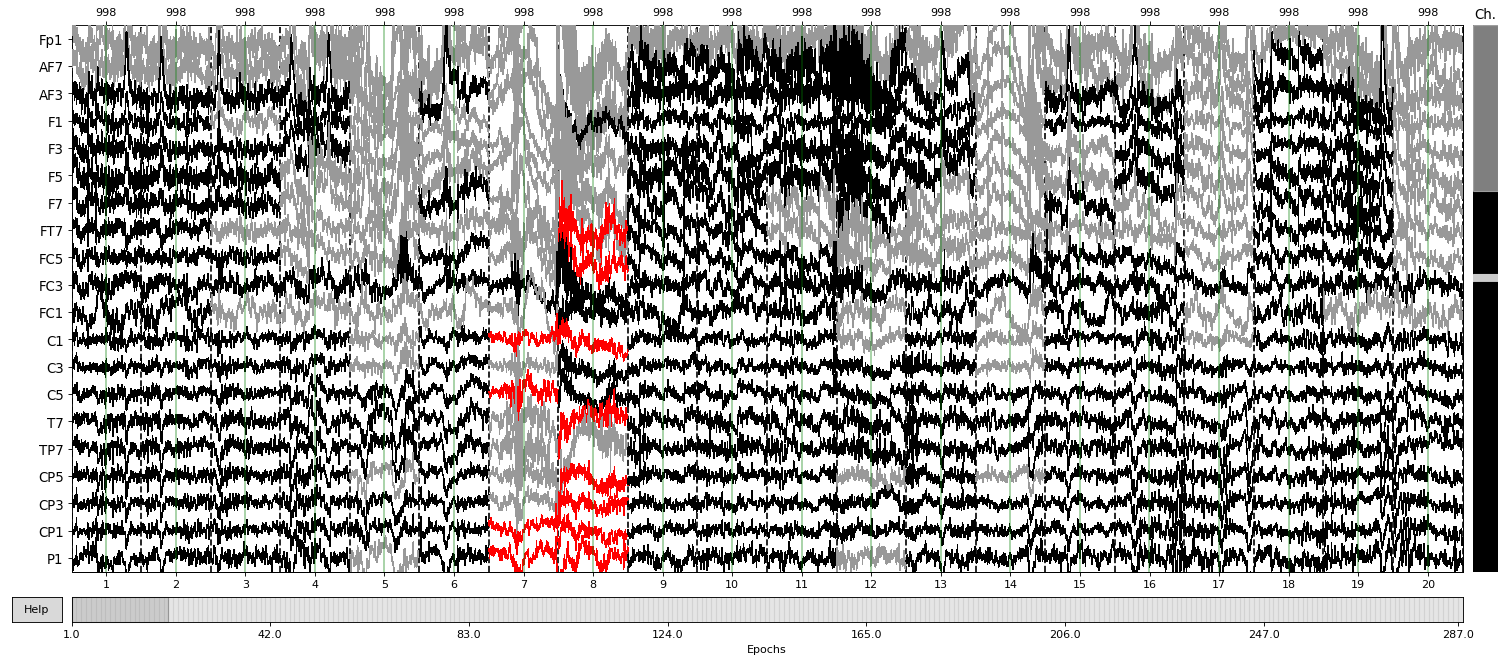

Embedding : jquery-1.10.2.min.js
Embedding : jquery-ui.min.js
Embedding : bootstrap.min.js
Embedding : jquery-ui.min.css
Embedding : bootstrap.min.css


In [7]:
#debug from local laptop
# yes !!
from autoreject import read_auto_reject
import mne
from mne.report import Report
subj='94'
state='FA1'
raw_data_path = 'E:/important file/INSERM/data_eeglab/raw_data/'
filt_data_path = 'E:/important file/INSERM/data_eeglab/filt_data/'
ica_file_path = 'E:/important file/INSERM/data_eeglab/ica_file/'
montage_path = "C:/Users/aegea/python/INSERM/raw_data/Biosemi64_MAS_EOG.locs"
first_ar_file_path = 'E:/important file/INSERM/data_eeglab/first_ar_file/'
epochs_raw_path = 'E:/important file/INSERM/data_eeglab/raw_epochs_data/'
f_first_autorej_ar = first_ar_file_path + 'subj0'+str(subj)+'_'+state+'_first_ar.fif'
ar_first= read_auto_reject(f_first_autorej_ar)
f_epochs_raw = epochs_raw_path + 'subj0'+str(subj)+'_'+state+'_raw_epo.fif'
epochs_raw=mne.read_epochs(f_epochs_raw)
reject_log=ar_first.get_reject_log(epochs_raw)
figs= list()
figs.append(reject_log.plot_epochs(epochs_raw))
captions=('first ar rejecting rate')
rep = Report(image_format = 'png', subject = 'subj0'+subj, raw_psd = True)
rep.add_figs_to_section(figs=figs, captions=captions, section = 'autorej plot', image_format = 'svg')